# INTRODUCTION TO MACHINE LEARNING PROJECT

## Imports

In [47]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# NOTES
# TODO show that the train test creation is really random, i.e that every class has 1/3 chance of being the majority class over all the dataset
# TODO make doxygen-like comments ?
# TODO confirm the experimental results with theoretical results
# TODO not sure normalization is needed for the features ?
# TODO weighting the closest points ?
# TODO improve calculations by using linear algebra 
# TODO calculate variance and std to know the right number of folds
# TODO fix the random seed ?
# TODO do PCA function from scratch
# TODO for the best k, redo cross val to tune the best distance metric
# TODO mixing/averaging distances metrics and compare the scores
# TODO for Q2 reducing complexity : we have to test the test set on prediction over the training set, otherwise doesn't make sense. So for Q1 do we have to predict test set on the training set or to predict test set amongst test set itself
# TODO modify assert into raise ValueError for user input verif
# TODO PRECOMPUTE THE DISTANCES OF THE TRAINING SET before cross-val


## Loading Data

In [39]:
from sklearn.decomposition import PCA

# Assuming features is a NumPy array
def plot_pca(x_train, y_train, train_point_size=10):
    # Applying PCA to reduce to 2 dimensions for visualization
    pca = PCA(n_components=2)
    x_train_pca = pca.fit_transform(x_train)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, cmap='viridis', marker='o', s=train_point_size)

    plt.colorbar(scatter)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

    
def load_data(dataset_file):
    return np.loadtxt(dataset_file, delimiter=',')

data = load_data('./waveform.data')

# Splitting the features and the labels into two different arrays
features = np.array(data[:,:data.shape[1]-1])

# Normalization of the features such that each feature has a mean = 0 and std = 1
def normalization(feat_to_norm) :
    new = np.empty(shape=feat_to_norm.shape)
    for i in range(feat_to_norm.shape[1]) :
        mean = np.mean(feat_to_norm[:,i])
        std = np.std(feat_to_norm[:,i])
        new[:,i] = (feat_to_norm[:,i] - mean) / std
    return new

features = normalization(feat_to_norm=features)

labels = np.array(data[:,data.shape[1]-1:])

###  Creating the dataset in python

In [40]:
def train_test_split(features, labels, train_ratio):
    assert features.shape[0] == labels.shape[0], "Error : dimensions of features and labels should be the same"

    # Randomly shuffling the dataset's indices to pick randomly the training and test examples
    shuffled_indices = np.arange(features.shape[0])
    np.random.shuffle(shuffled_indices)
    train_size = int(len(shuffled_indices) * train_ratio)
    train_indices = shuffled_indices[:train_size]
    test_indices = shuffled_indices[train_size:]

    x_set = features[train_indices]
    x_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]

    assert x_set.shape[0] == y_train.shape[0], "Error : creation of training set went wrong."
    assert x_test.shape[0] == y_test.shape[0], "Error : creation of testing set went wrong."

    return x_set, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_split(features, labels, 0.8)

print("Training set : "+str(x_train.shape[0])+" examples.\nTest set : "+str(x_test.shape[0])+" examples.")
nb_classes_train = np.unique(y_train, return_counts=True)
nb_classes_test = np.unique(y_test, return_counts=True)
print("Distribution of classes for the Training set : ")
print(nb_classes_train[0])
print(nb_classes_train[1])
print("Distribution of classes for the Test set : ")
print(nb_classes_test[0])
print(nb_classes_test[1])

Training set : 4000 examples.
Test set : 1000 examples.
Distribution of classes for the Training set : 
[0. 1. 2.]
[1344 1320 1336]
Distribution of classes for the Test set : 
[0. 1. 2.]
[313 327 360]


### Various functions

In [41]:
# Returns an array with the euclidian distances from x to every x' in x_array
def euclidian_dist_array(x, x_array):
    return np.linalg.norm(x_array - x, axis=1).reshape(-1, 1)

# TO be tried in terms of time complexity
""" def euclidian_dist_array(x_array, x_train):
    return np.sqrt(np.sum((x_array - x_train[:, np.newaxis]) ** 2, axis=2))
 """

def accuracy(nb_true, nb_total):
    return (nb_true * 100) / nb_total

## KNN Algorithm

In [42]:
# Returns the majority class from the features amongst the k nearest neighbors of new_input 
def knn(new_input, features, labels, k):
    # Computing the distance from new_input to every x in features
    dist_array = euclidian_dist_array(new_input, features)

    # Associating the distance array with their corresponding labels
    dist_array_labeled = np.hstack([dist_array, labels])

    # Sorting the array by increasing distance order (keeping the labels associated)
    sorted_indices = np.argsort(dist_array_labeled[:, 0])
    sorted_array = dist_array_labeled[sorted_indices]

    # Count the number of occurences of each class Yj among the k nearest neighbors
    label, counts = np.unique(sorted_array[:k, 1], return_counts=True, axis=0)
    results = dict(zip(label, counts))

    # Returning the majority class among the k nearest neighbors
    majority_class = max(results, key=results.get)
    return majority_class

# Returns the accuracy of the prediction of the x_set_test amongst the x_set_train
def prediction_metrics(x_set_train, y_set_train, x_set_test, y_set_test, k):
    right_predictions = 0
    assert x_set_train.shape == x_set_train.shape, "Error : x_set_train, x_set_test not the same shape"
    total_predictions = len(x_set_test)

    classes = np.unique(y_set_test)
    nb_classes = len(classes)
    confusion_matrix = np.zeros((nb_classes, nb_classes))

    for i in range(total_predictions) :
        y_pred = knn(x_set_test[i], x_set_train, y_set_train, k)
        y_actual = y_set_test[i, 0]

        if (y_pred == y_actual):
            right_predictions +=1

        index_pred = np.where(classes == y_pred)[0][0]
        index_actual = np.where(classes == y_actual)[0][0]
        confusion_matrix[index_actual, index_pred] += 1

    accuracy = (right_predictions * 100) / total_predictions
    return accuracy, confusion_matrix


## Tuning k by cross-validation

In [43]:
#Splitting the training set into x_subsets for cross-validation
def k_folds(x_training_set, y_training_set, nb_folds):
    if nb_folds > x_training_set.shape[0]:
        raise ValueError("Error : number of folds exceeding the number of samples in the dataset.")
    # Shuffling the sets to get random folds
    indices = np.arange(x_training_set.shape[0])
    np.random.shuffle(indices)
    x_shuffled = x_training_set[indices]
    y_shuffled = y_training_set[indices]
    
    # Split the shuffled data into folds
    x = np.array_split(x_shuffled, nb_folds)
    y = np.array_split(y_shuffled, nb_folds)

    assert len(x) == len(y), "Error creating the subsets for cross-validation"
    return x, y

# Returns the metrics for a given k using cross-validation
def cross_validation(k, x_train_folds, y_train_folds, nb_folds):
    fold_accuracies = []
    fold_confusion_matrices = []

    # Computing the metrics for each fold taken once(as a validation fold) over the k-1 training folds
    for i in range(nb_folds):
        # Remove the validation set from the training set
        x_tmp_training = np.concatenate([x_train_folds[j] for j in range(nb_folds) if j != i], axis=0)
        y_tmp_training = np.concatenate([y_train_folds[j] for j in range(nb_folds) if j != i], axis=0)

        # Take the remaining fold as the validation fold
        x_val_fold = x_train_folds[i]
        y_val_fold = y_train_folds[i]

        fold_accuracy, fold_cm = (prediction_metrics(x_set_train=x_tmp_training, y_set_train=y_tmp_training, 
                                                     x_set_test=x_val_fold, y_set_test=y_val_fold, 
                                                     k=k))
        fold_accuracies.append(fold_accuracy)
        fold_confusion_matrices.append(fold_cm)

    print("Validation folds accuracies :"+str(fold_accuracies))
    
    # Returning the mean of the metrics
    mean_accuracy = np.mean(fold_accuracies)
    mean_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
    return mean_accuracy, mean_confusion_matrix

# Returns the best k using cross-validation
def tuning_k(nb_folds, x_folds, y_folds, k_range):
    list_accuracies = []
    list_confusion_matrices = []

    # Iterate over the whole k range
    for k in k_range : 
        print("k = "+str(k))
        # Get the mean metrics for this k over the entire folds using cross-validation
        mean_acc, mean_cm = cross_validation(k, x_folds, y_folds, nb_folds)
        list_accuracies.append(mean_acc)  
        list_confusion_matrices.append(mean_cm)
        print("Mean accuracy = "+str(mean_acc))
        print("Confusion Matrix : \n"+str(mean_cm))

    max_accuracy = max(list_accuracies)
    best_k = k_range[list_accuracies.index(max_accuracy)] 

    # Returning the best k found, the mean accuracies for each k over the folds, and the mean CM for each k
    return best_k, list_accuracies, list_confusion_matrices

nb_folds = 5
x_subsets, y_subsets = k_folds(x_train, y_train, nb_folds)
k_max = int(x_train.shape[0] - (x_train.shape[0] / nb_folds))
k_range = range(1, 100)
best_k, accuracies, confusion_matrices = tuning_k(nb_folds=nb_folds, x_folds=x_subsets, y_folds=y_subsets, k_range=k_range)
max_accuracy = max(accuracies)


k = 1
Validation folds accuracies :[76.625, 76.75, 77.5, 74.875, 75.375]
Mean accuracy = 76.225
Confusion Matrix : 
[[192.6  38.6  37.6]
 [ 31.8 209.6  22.6]
 [ 34.   25.6 207.6]]
k = 2
Validation folds accuracies :[75.125, 77.0, 76.75, 74.25, 74.5]
Mean accuracy = 75.525
Confusion Matrix : 
[[231.2  18.   19.6]
 [ 54.6 201.    8.4]
 [ 55.2  40.  172. ]]
k = 3
Validation folds accuracies :[80.5, 80.625, 81.75, 79.875, 78.875]
Mean accuracy = 80.325
Confusion Matrix : 
[[199.   35.2  34.6]
 [ 26.2 219.8  18. ]
 [ 23.8  19.6 223.8]]
k = 4
Validation folds accuracies :[80.5, 80.25, 82.125, 80.125, 78.625]
Mean accuracy = 80.325
Confusion Matrix : 
[[225.8  21.8  21.2]
 [ 38.6 214.4  11. ]
 [ 34.8  30.  202.4]]
k = 5
Validation folds accuracies :[81.0, 81.75, 82.875, 82.25, 81.375]
Mean accuracy = 81.85
Confusion Matrix : 
[[201.2  33.8  33.8]
 [ 23.4 224.2  16.4]
 [ 20.   17.8 229.4]]
k = 6
Validation folds accuracies :[81.125, 81.375, 82.875, 82.25, 79.75]
Mean accuracy = 81.475
Confusio

### Plotting of the accuracies w.r.t k

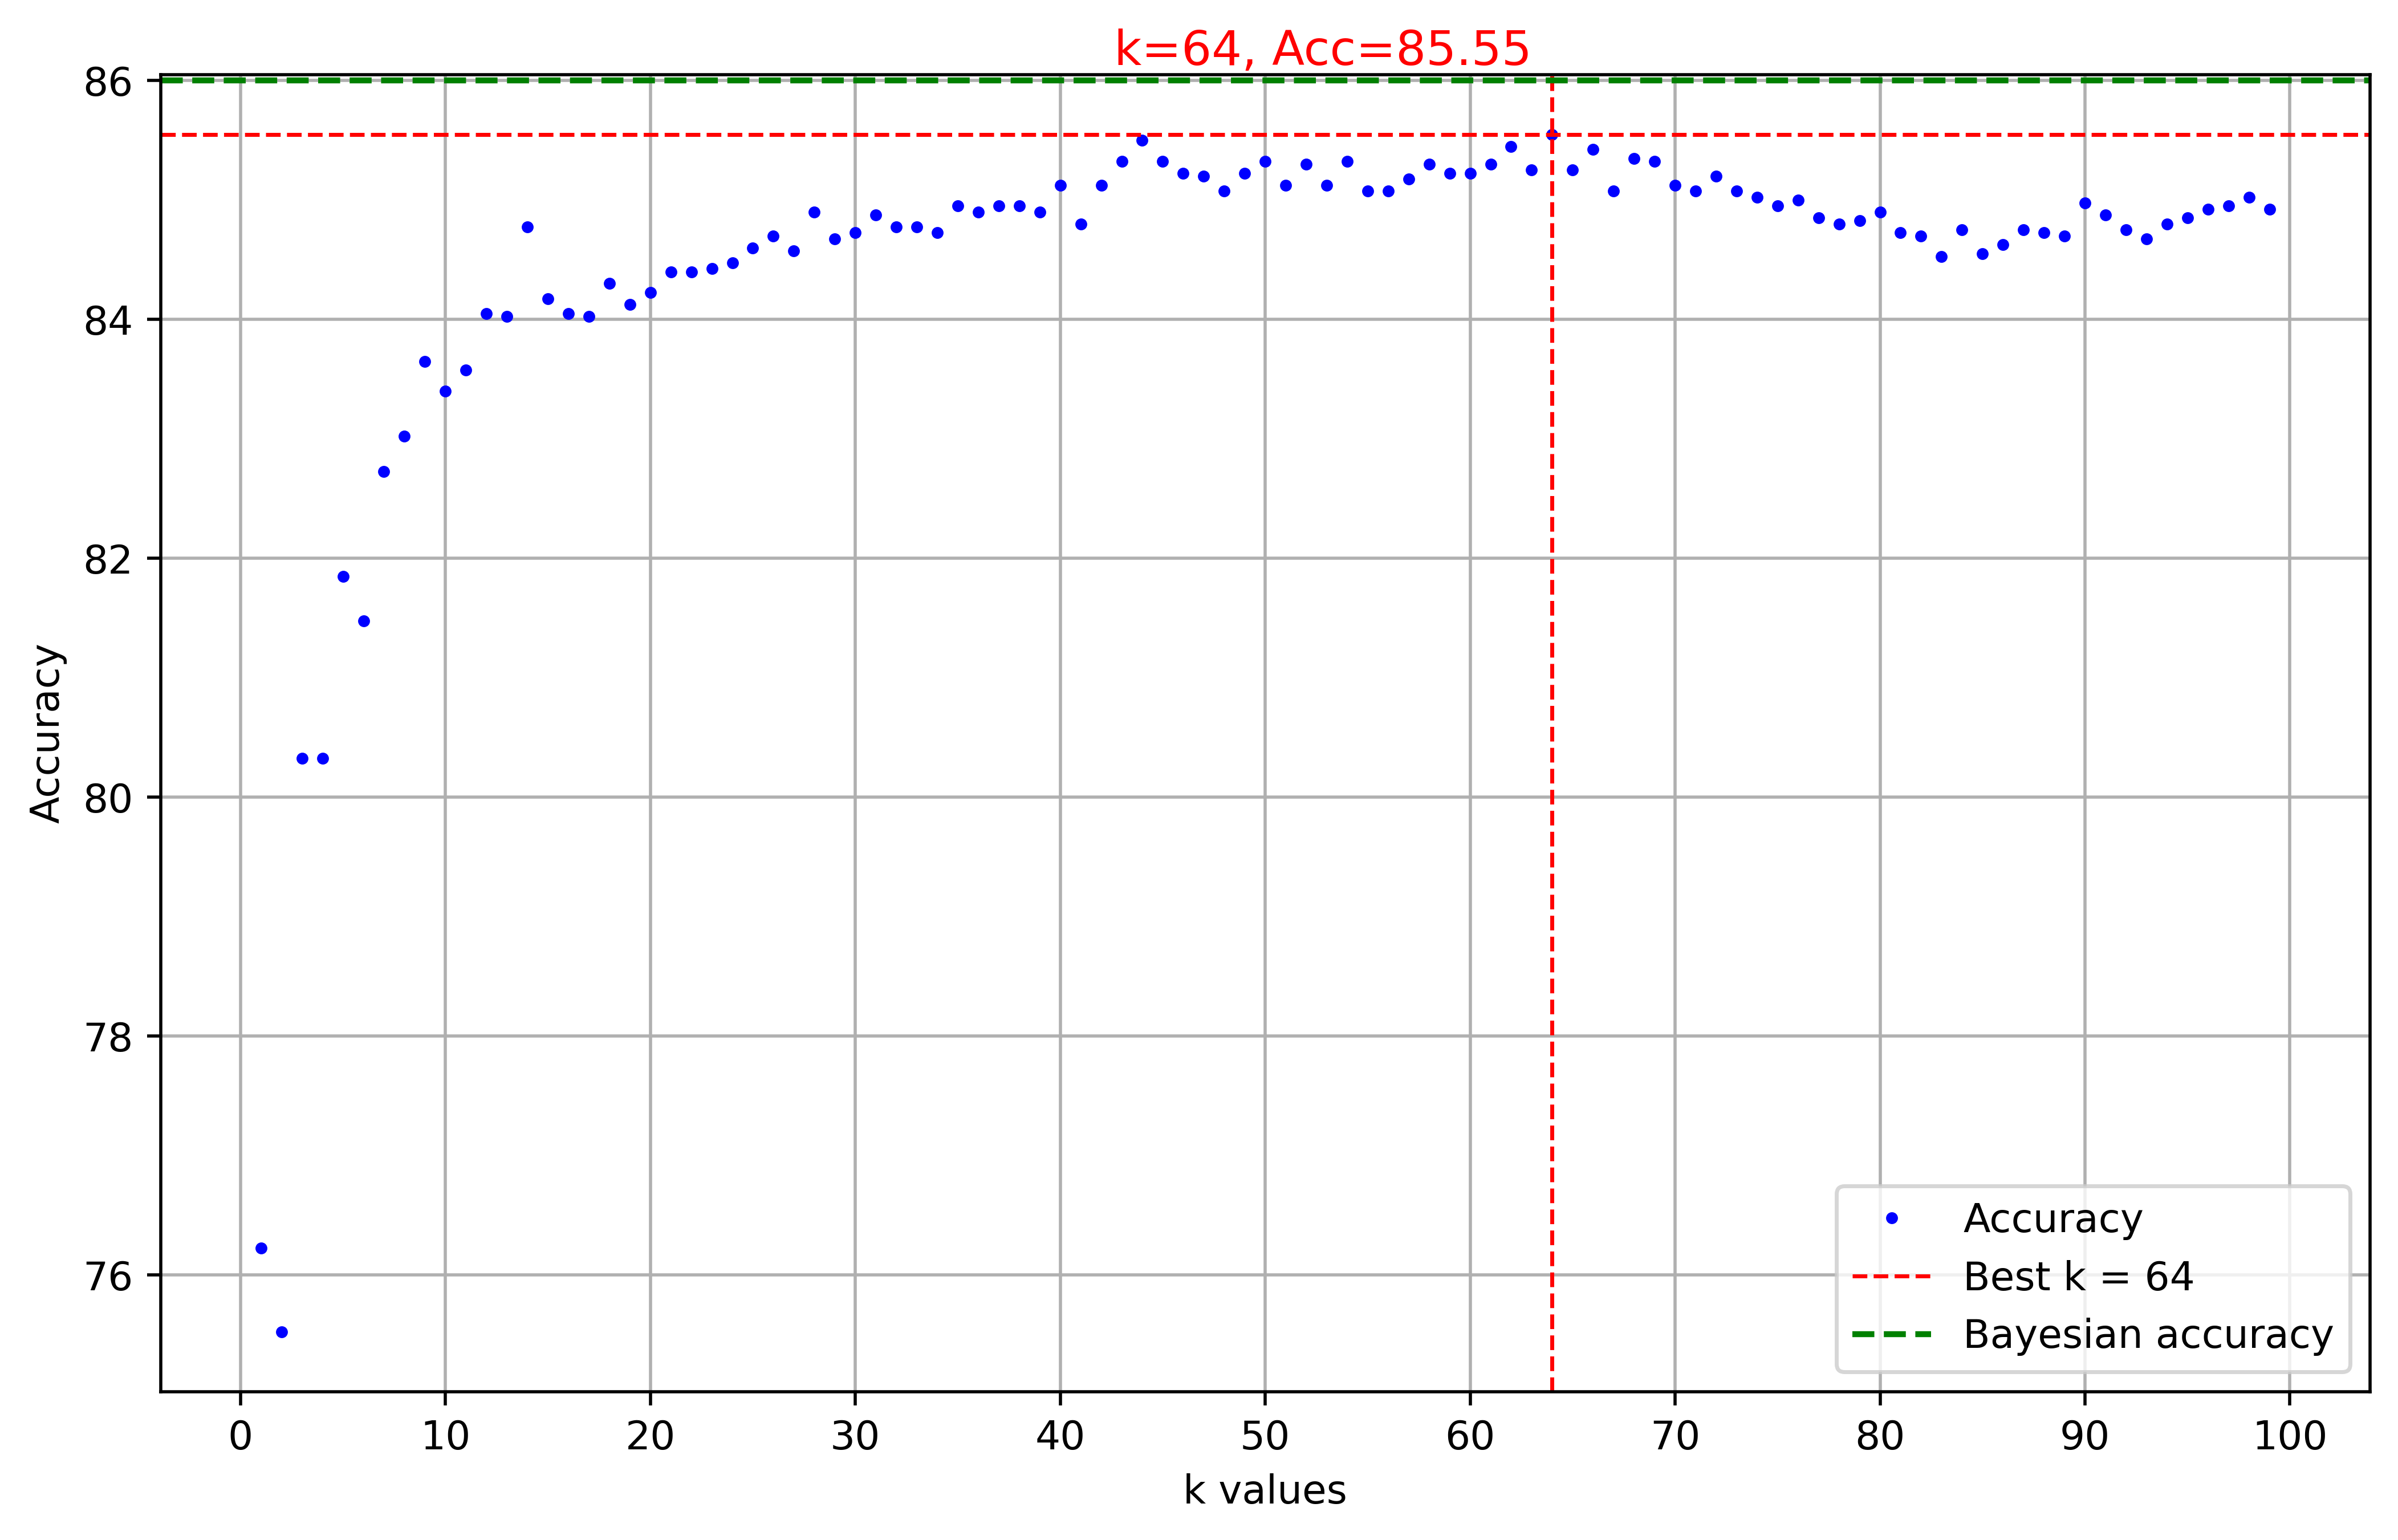

In [44]:
plt.figure(figsize=(10, 6), dpi=500) 
plt.plot(k_range, accuracies, label='Accuracy', marker='o', color='b',markersize=2,linestyle='None')
plt.axvline(x=best_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {best_k}')
plt.axhline(y=max_accuracy, color='r', linestyle='--', linewidth=1)
plt.axhline(y=86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.text(best_k-1, max_accuracy+.5, f'k={best_k}, Acc={max_accuracy:.2f}', 
         horizontalalignment='right', verticalalignment='bottom', 
         color='red', fontsize=12)
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, max(k_range)+2, 10)) 
plt.grid(True)
plt.legend()
plt.show()


### Confusion matrix of the best k

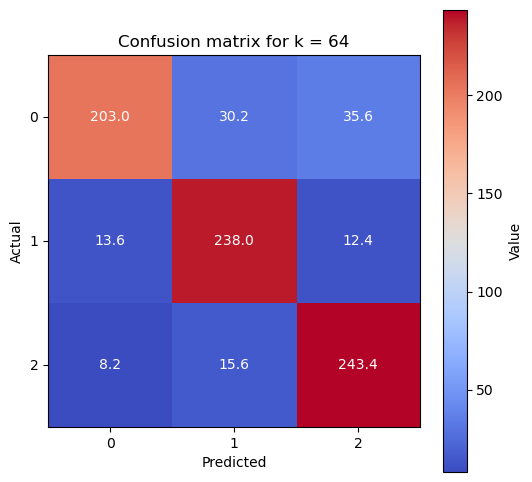

In [45]:
def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, cmap='coolwarm')
    plt.colorbar(label='Value')
    for (i, j), value in np.ndenumerate(matrix):
        plt.text(j, i, f'{value}', ha='center', va='center', color='white')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.xticks(np.arange(matrix.shape[1]), ['0', '1', '2'])
    plt.yticks(np.arange(matrix.shape[0]), ['0', '1', '2'])
    plt.show()

confusion_mat_best_k = confusion_matrices[accuracies.index(max_accuracy)]
plot_confusion_matrix(confusion_mat_best_k,"Confusion matrix for k = "+str(best_k))

### Prediction on the test set using the best k found

Accuracy : 86.0


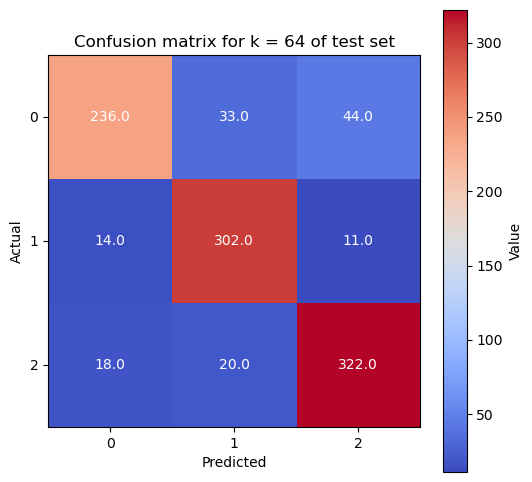

In [46]:
# Prediction of the test set
# For each example in the test set, predict it using the training set and the best k found
test_acc, test_cm = prediction_metrics(x_set_train=x_train, y_set_train=y_train, x_set_test=x_test, y_set_test=y_test, k=best_k)
print("Accuracy : "+str(test_acc))
plot_confusion_matrix(test_cm,"Confusion matrix for k = "+str(best_k)+" of test set")


# Reducing complexity